In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchsummary import summary

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# fix seed
np.random.seed(0)

## Data

In [2]:
# means and standard deviations ImageNet because the network is pretrained
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms to apply to each image
transf = transforms.Compose([ #transforms.Resize(227),      # Resizes short size of the PIL image to 256
                              transforms.CenterCrop(224),  # Crops a central square patch of the image 224 because torchvision's AlexNet needs a 224x224 input!
                              transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                              transforms.Normalize(means,stds) # Normalizes tensor with mean and standard deviation
])

In [3]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

# Define datasets root
DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

# Check dataset sizes
print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [4]:
# concat all datasets
full_dataset = torch.utils.data.ConcatDataset([photo_dataset, art_dataset, cartoon_dataset, sketch_dataset])

# Split dataset into train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [5]:
# Create Dataloaders
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Model

In [6]:
from torchvision.models import mobilenet_v3_small

class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.backbone = mobilenet_v3_small(pretrained=True)
        self.backbone.classifier = nn.Sequential()
        
        self.head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(576, 256)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(256, num_classes))
        ]))

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

In [7]:
model = Model(num_classes=7).to(device)

/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gb2t/anaconda3/envs/duc_open_sora/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [9]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            # loss
            loss = criterion(outputs, labels)
        
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [10]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [11]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # loss
        loss= criterion(outputs, labels)
                    
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{(epoch + 1):2}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.3f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [ 1/ 30] 	 Loss: 1.53382     Accuracy: 52.936% 	 Test Loss: 0.99895     Test Accuracy: 69.63%
Epoch [ 2/ 30] 	 Loss: 0.66618     Accuracy: 80.885% 	 Test Loss: 0.57919     Test Accuracy: 81.14%
Epoch [ 3/ 30] 	 Loss: 0.36460     Accuracy: 88.256% 	 Test Loss: 0.41443     Test Accuracy: 85.49%
Epoch [ 4/ 30] 	 Loss: 0.24315     Accuracy: 92.011% 	 Test Loss: 0.36130     Test Accuracy: 87.39%
Epoch [ 5/ 30] 	 Loss: 0.16747     Accuracy: 94.556% 	 Test Loss: 0.34699     Test Accuracy: 87.64%
Epoch [ 6/ 30] 	 Loss: 0.11634     Accuracy: 96.459% 	 Test Loss: 0.33512     Test Accuracy: 88.19%
Epoch [ 7/ 30] 	 Loss: 0.07717     Accuracy: 97.959% 	 Test Loss: 0.36899     Test Accuracy: 88.04%
Epoch [ 8/ 30] 	 Loss: 0.05055     Accuracy: 98.841% 	 Test Loss: 0.35556     Test Accuracy: 89.04%
Epoch [ 9/ 30] 	 Loss: 0.03947     Accuracy: 99.131% 	 Test Loss: 0.42768     Test Accuracy: 88.14%
Epoch [10/ 30] 	 Loss: 0.02674     Accuracy: 99.483% 	 Test Loss: 0.37179     Test Accuracy: 89.09%


In [12]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%")


Best epoch: 16 with test accuracy: 90.40%


# Plot results

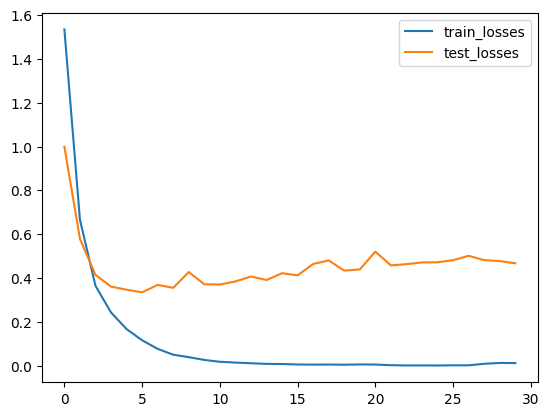

In [13]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

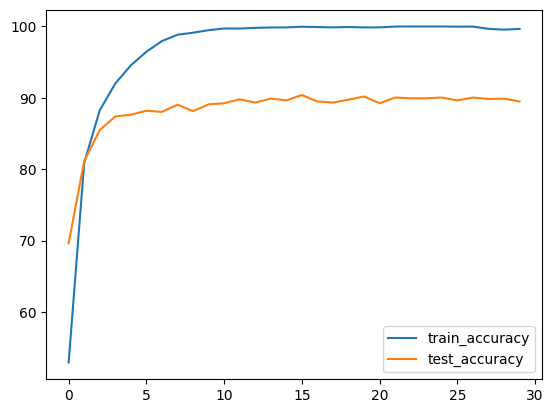

In [14]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [15]:
# save model
# torch.save(model.state_dict(), 'mobilenetv3_small.pth')